In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision

from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_style("darkgrid")

from mean_teacher import datasets, architectures
from mean_teacher.utils import *

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
to_image = transforms.ToPILImage()

%matplotlib inline

In [2]:
def load_weights(model_arch, pretrained_model_path, state_dict, cuda=True):
        # Load pretrained model
        pretrained_model = torch.load(f=pretrained_model_path, map_location="cuda" if cuda else "cpu")

        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in pretrained_model[state_dict].items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

        # Load pre-trained weights in current model
        with torch.no_grad():
            model_arch.load_state_dict(new_state_dict, strict=True)

        # Debug loading
        #print('Parameters found in pretrained model:')
        pretrained_layers = new_state_dict.keys()
        #for l in pretrained_layers:
        #    print('\t' + l)
        #print('')

        for name, module in model_arch.state_dict().items():
            if name in pretrained_layers:
                assert torch.equal(new_state_dict[name].cpu(), module.cpu())
                #print('{} have been loaded correctly in current model.'.format(name))
            else:
                raise ValueError("state_dict() keys do not match")
                
        return model_arch


In [3]:
dataset_config = datasets.__dict__['sslMini']()

In [4]:
BATCH_SIZE = 32

evaldir = "/scratch/ijh216/ssl_mini/supervised/val"

eval_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(evaldir, dataset_config['eval_transformation']),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=2,
                                              drop_last=False)


In [5]:
img_dir = eval_loader.dataset.imgs[0][0]
img = eval_loader.dataset[0][0].unsqueeze(0).to(device).detach()
img_class = eval_loader.dataset[0][1]

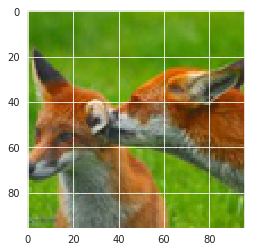

In [6]:
plt.imshow(io.imread(img_dir))

In [47]:
model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(0) 

model = architectures.__dict__['cifar_shakeshake26']().to(device)
ema_model = architectures.__dict__['cifar_shakeshake26']().to(device)

model = load_weights(model, model_dir, state_dict="state_dict", cuda=False)
ema_model = load_weights(ema_model, model_dir, state_dict="ema_state_dict", cuda=False)

with torch.no_grad():
    model_out = F.softmax(model(img)[0], dim=1)
    ema_model_out = F.softmax(ema_model(img)[0], dim=1)

dists = torch.cat((model_out, ema_model_out)).unsqueeze(0)

with torch.no_grad():
    for ckpt in tqdm(range(25, 415, 25)):
        if ckpt <= 325:
            model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(0) 
        else:
            model_dir = "/scratch/ijh216/ssl/ssl2/2019-05-09_17-19-21/10/transient/checkpoint.{}.ckpt".format(ckpt)
        
        model = architectures.__dict__['cifar_shakeshake26']().to(device)
        ema_model = architectures.__dict__['cifar_shakeshake26']().to(device)

        model = load_weights(model, model_dir, state_dict="state_dict", cuda=False)
        ema_model = load_weights(ema_model, model_dir, state_dict="ema_state_dict", cuda=False)

        model_out = F.softmax(model(img)[0], dim=1)
        ema_model_out = F.softmax(ema_model(img)[0], dim=1)

        outs = torch.cat((model_out, ema_model_out)).unsqueeze(0)
        dists = torch.cat((dists, outs))
    
    model_dir = "/scratch/ijh216/ssl/ssl2/2019-05-09_17-19-21/10/transient/checkpoint.415.ckpt"
    model_out = F.softmax(model(img)[0], dim=1)
    ema_model_out = F.softmax(ema_model(img)[0], dim=1)
    outs = torch.cat((model_out, ema_model_out)).unsqueeze(0)
    dists = torch.cat((dists, outs))
    


100%|██████████| 16/16 [00:48<00:00,  4.19s/it]

In [35]:
select_labels = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

In [23]:
colors = sns.color_palette('pastel', 2)

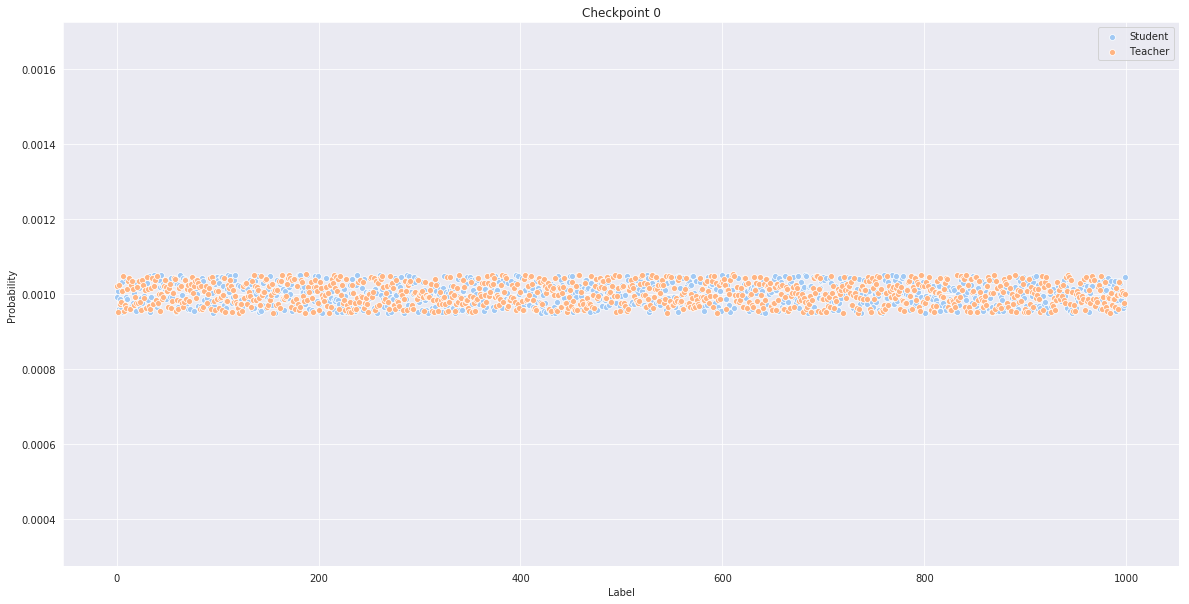

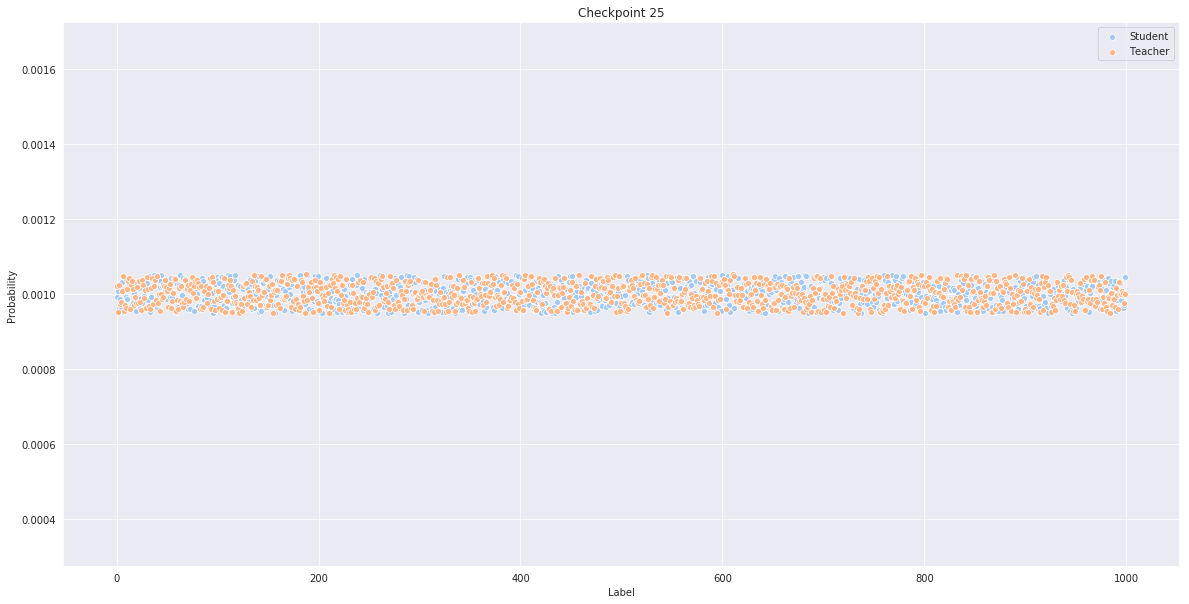

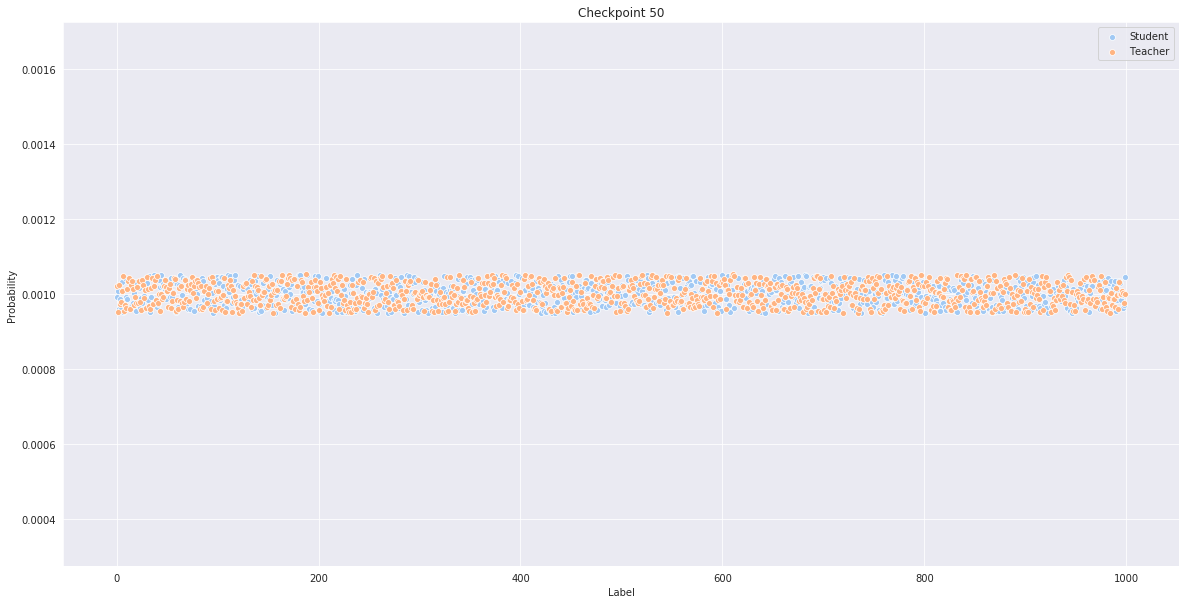

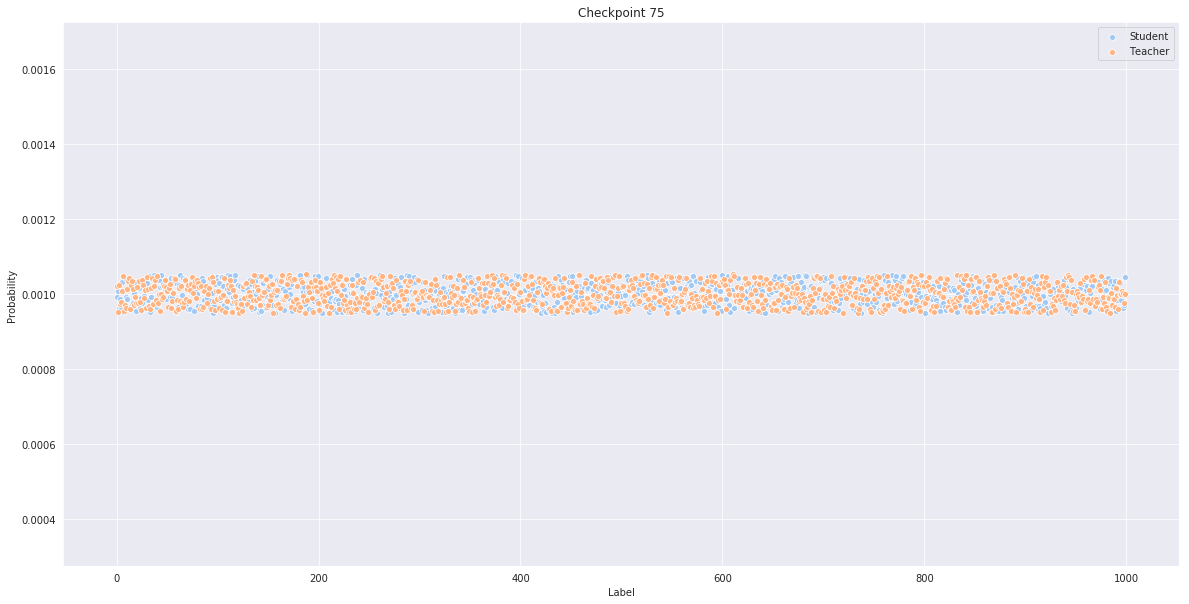

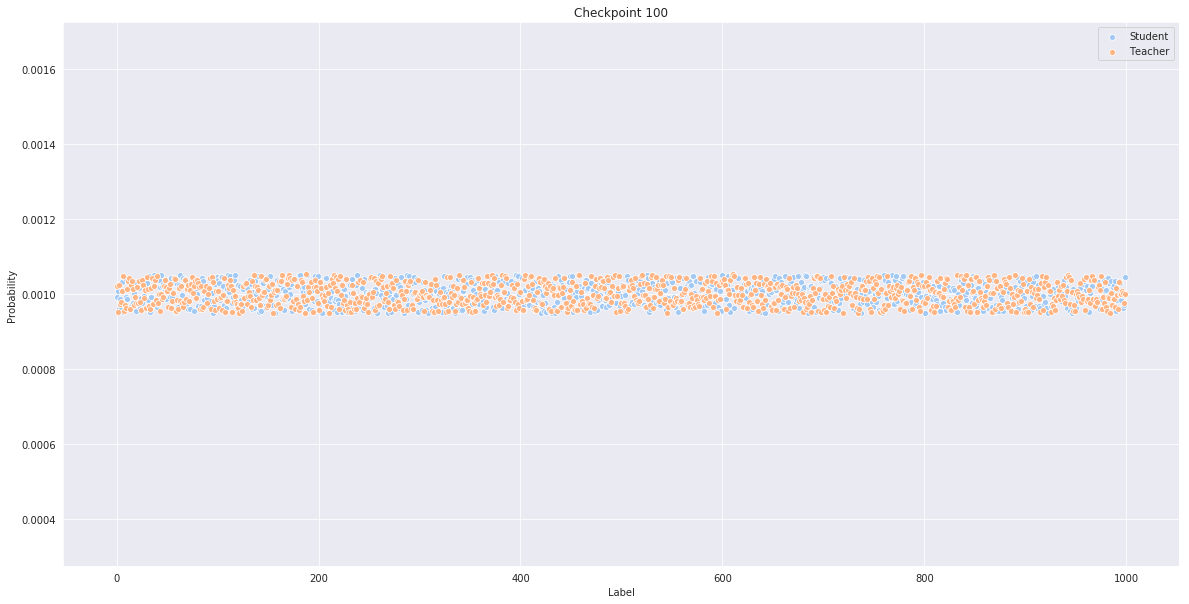

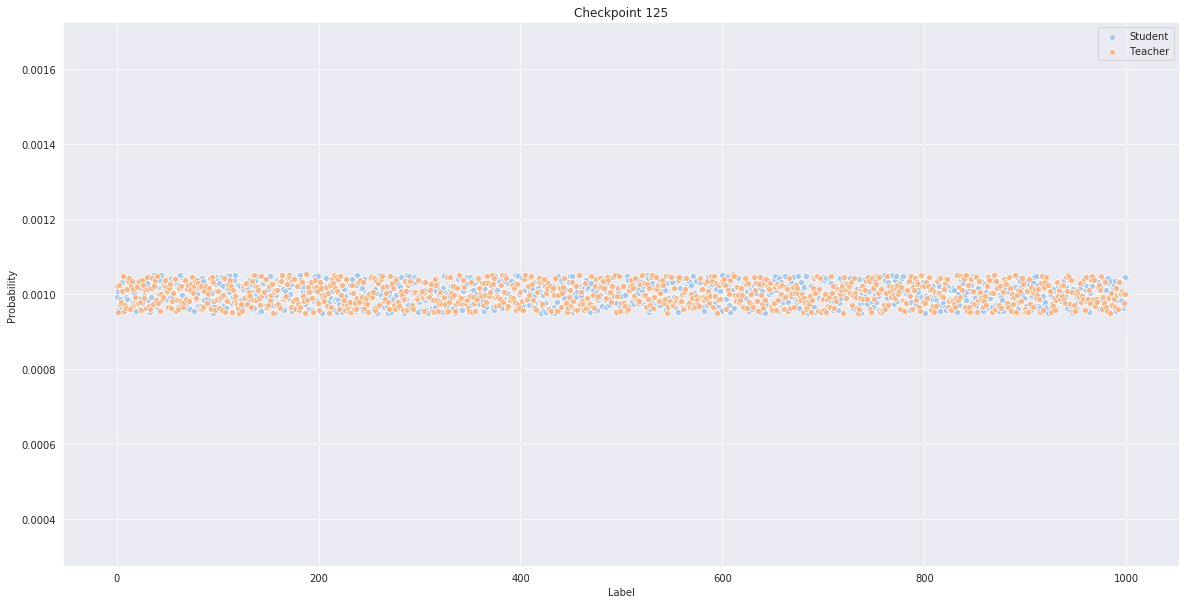

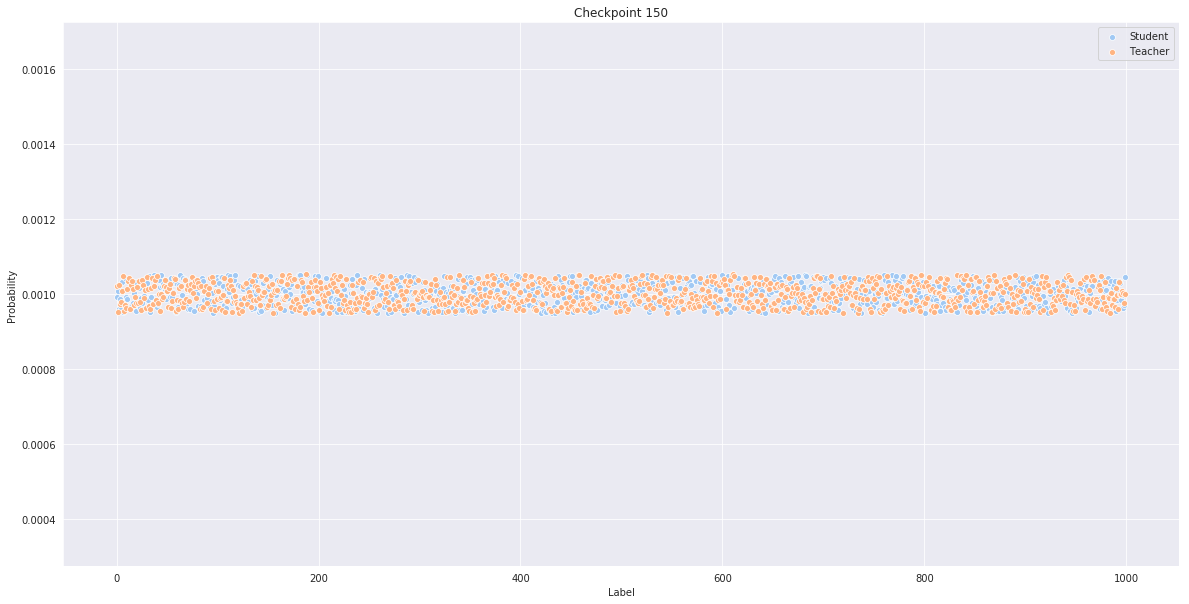

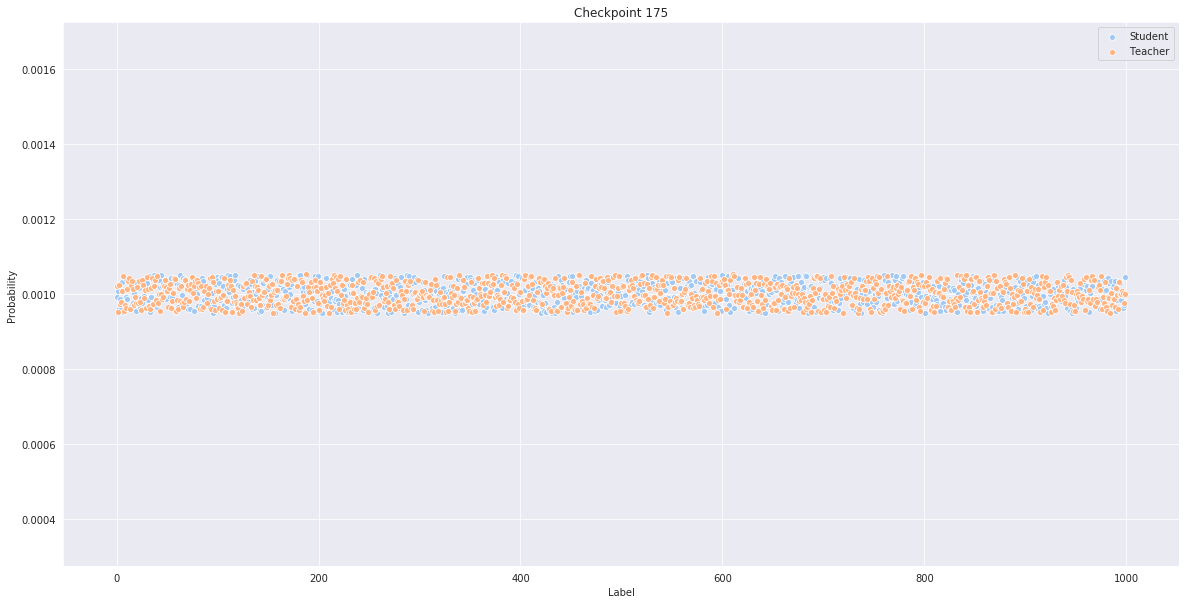

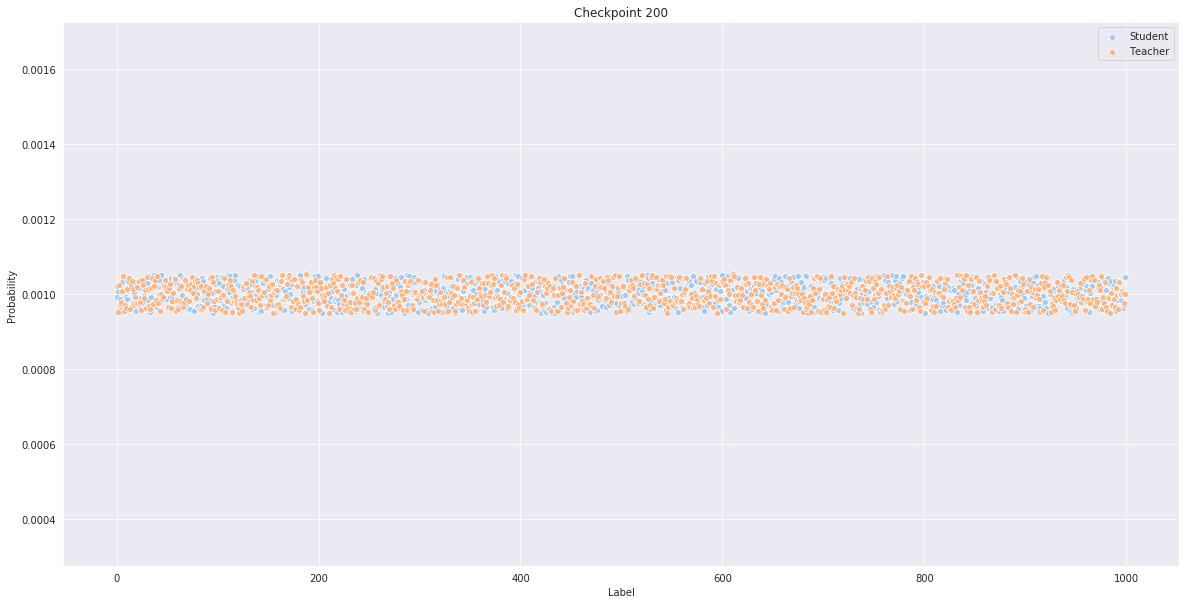

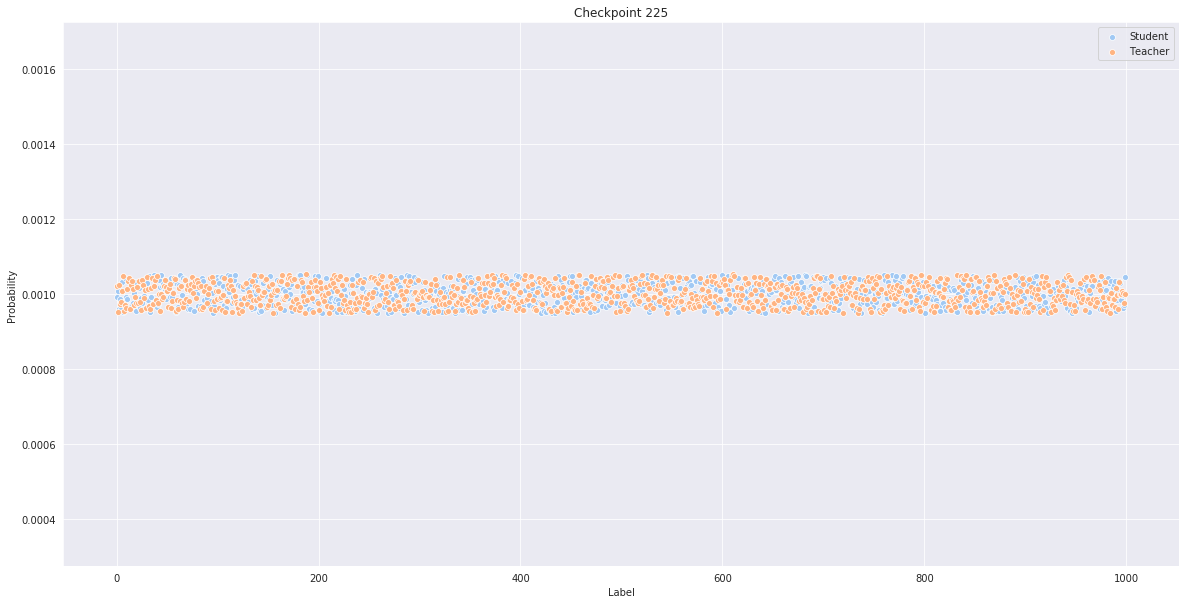

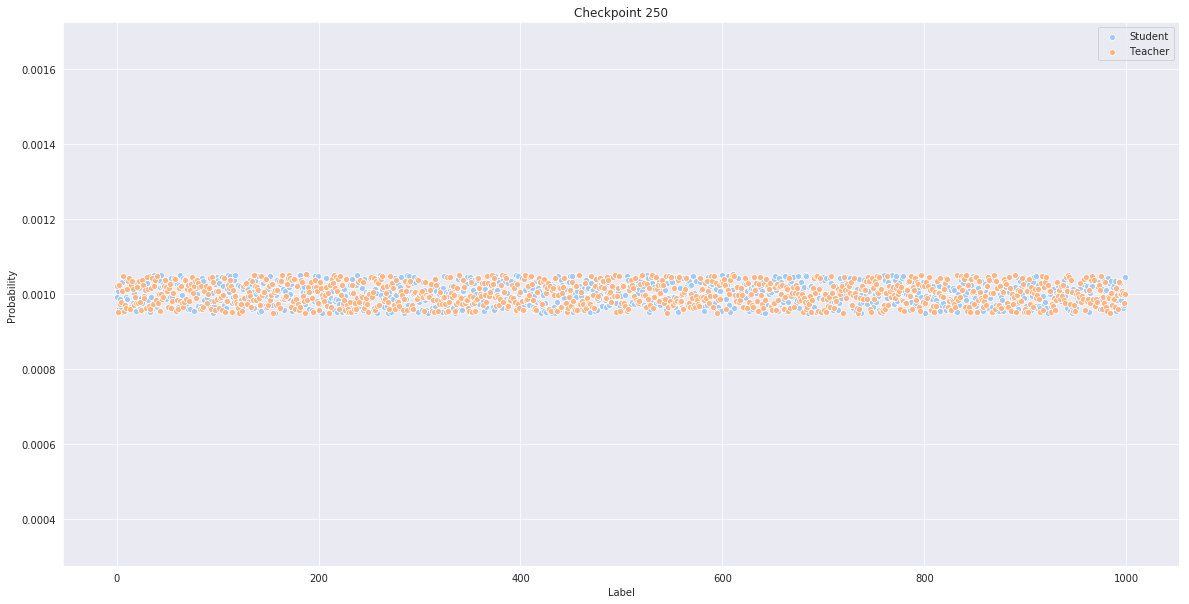

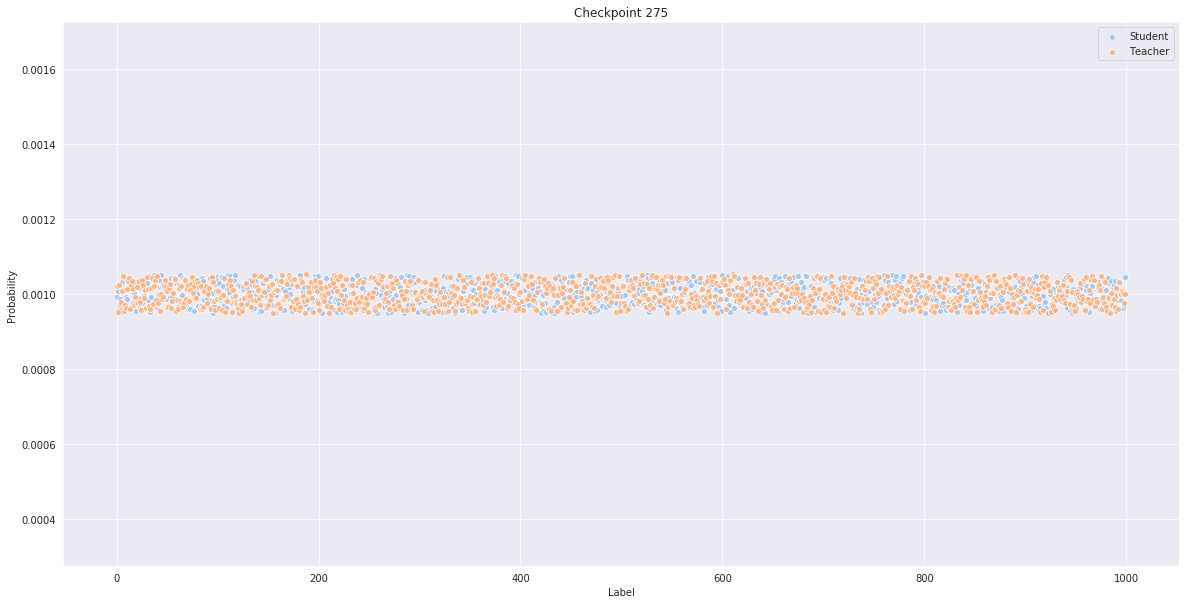

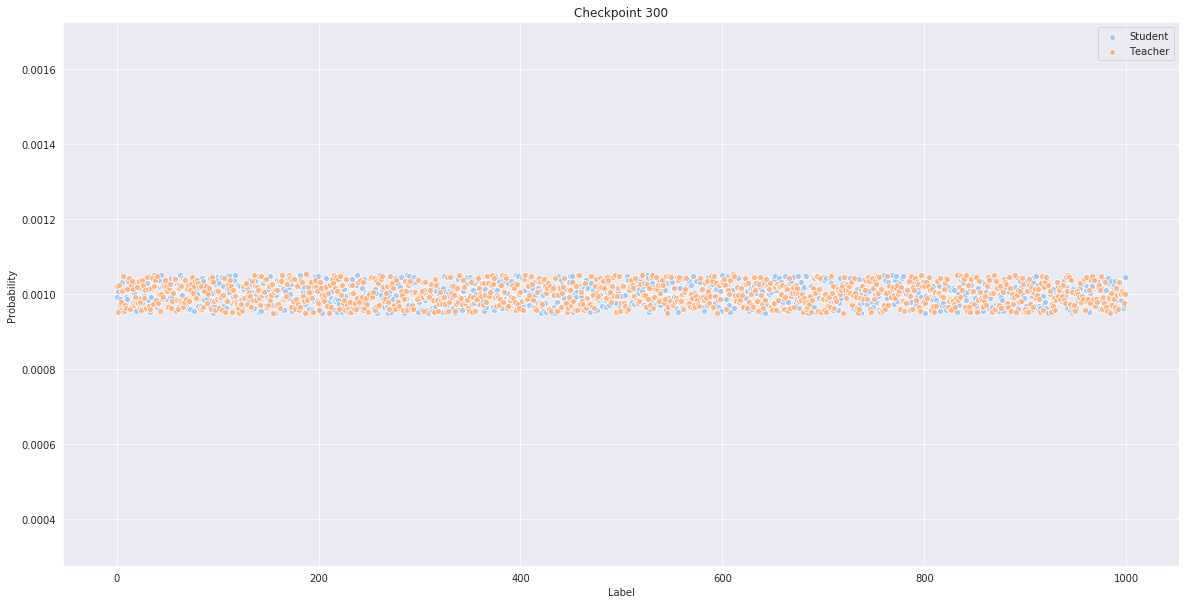

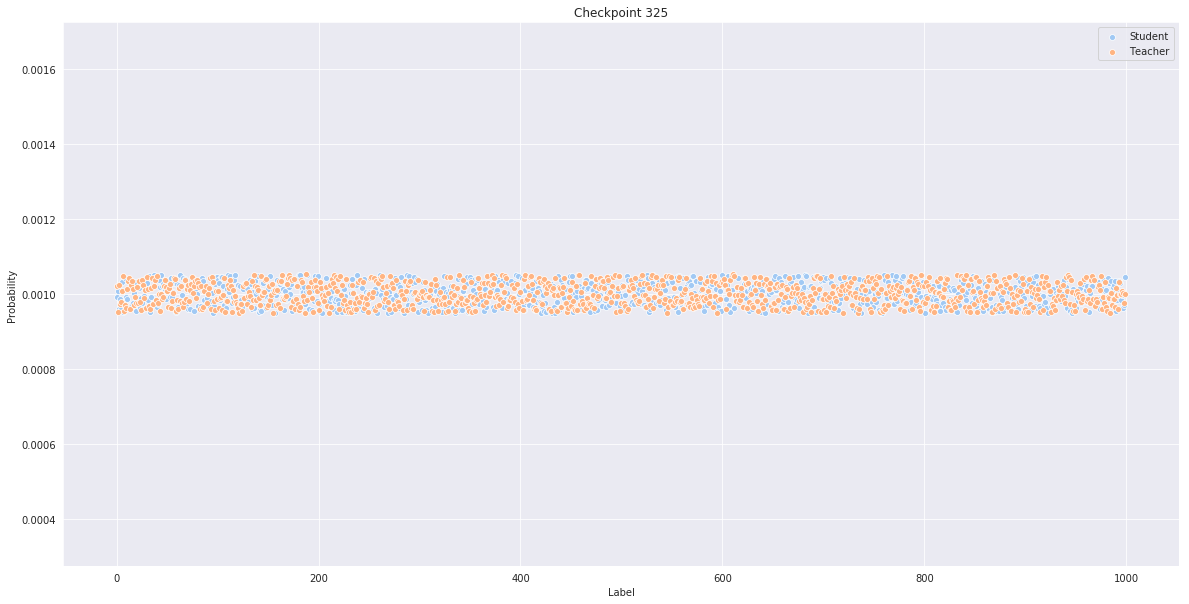

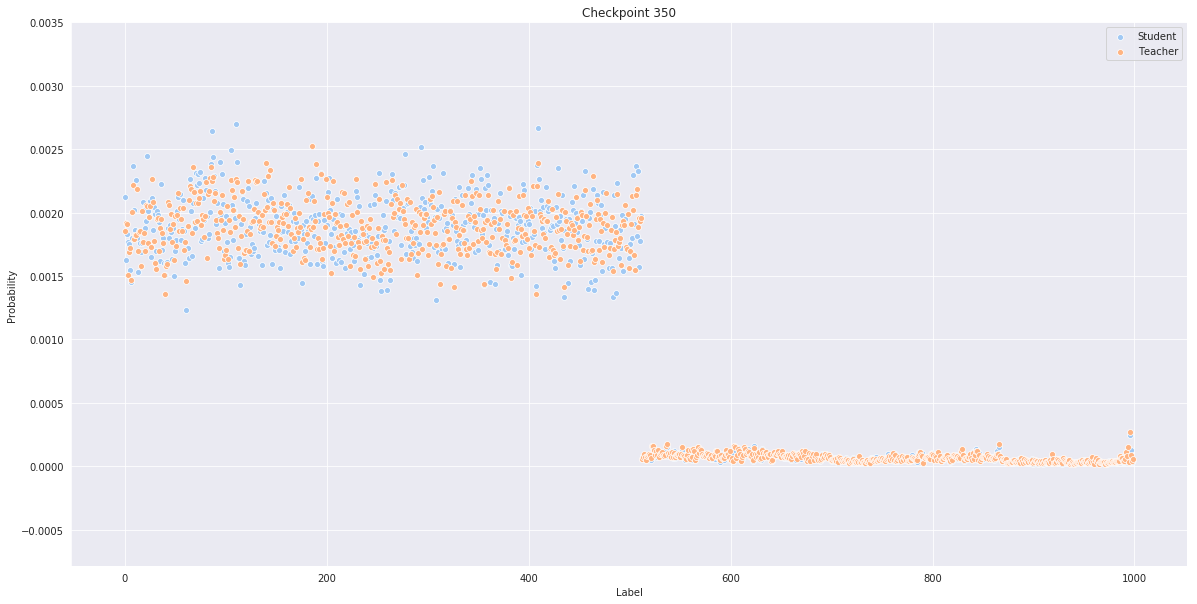

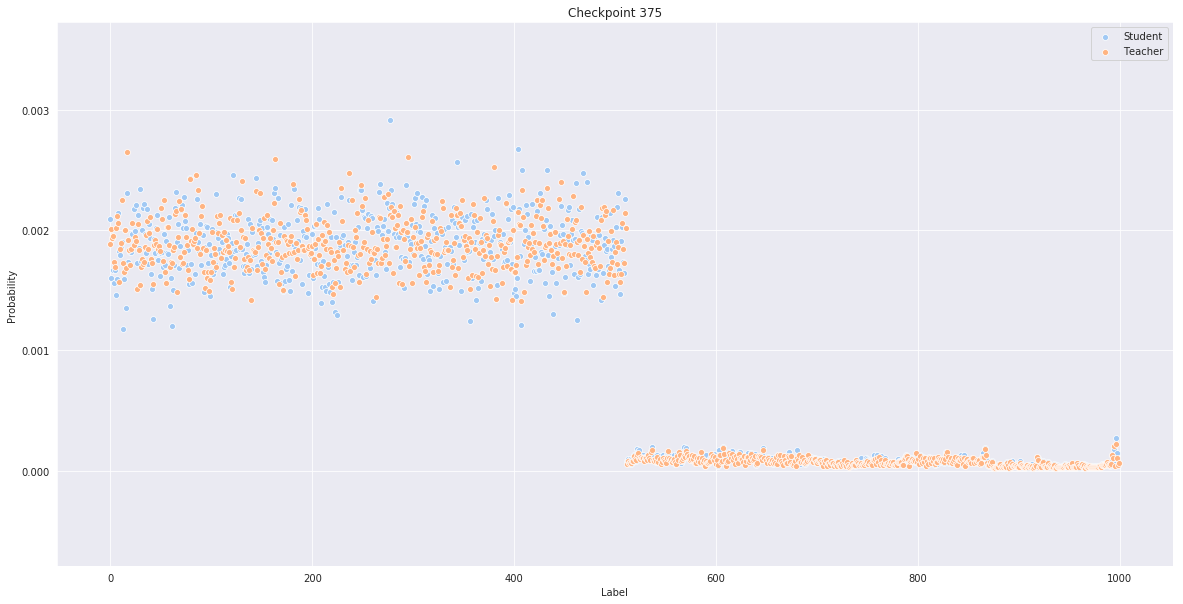

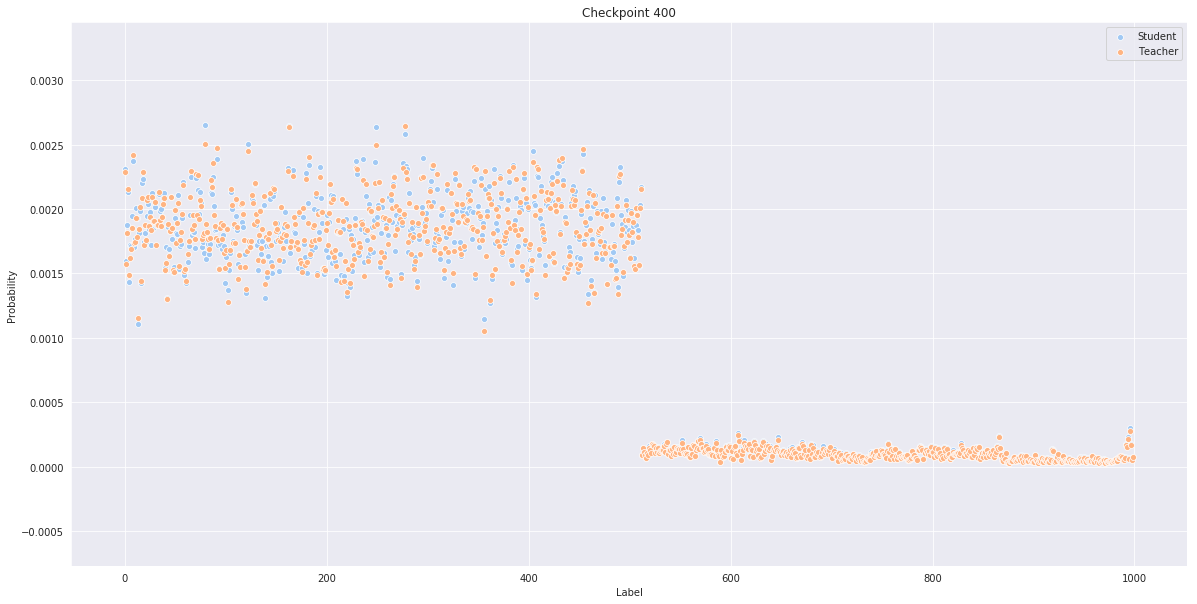

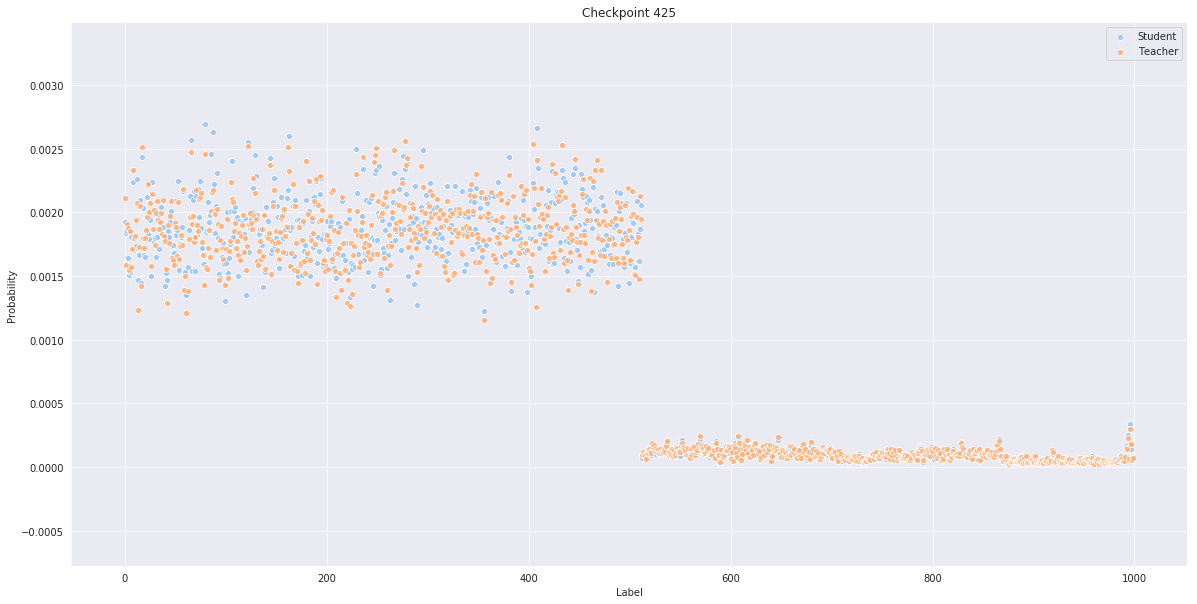

In [50]:
for i in range(dists.size(0)):

    label_dist = pd.DataFrame(dists[i].numpy())
    
    fig = plt.figure(figsize=(20,10))
    sns.scatterplot(label_dist.columns, 
                label_dist.iloc[0],
                color=colors[0],
                label="Student")
    sns.scatterplot(label_dist.columns, 
                label_dist.iloc[1],
                color=colors[1],
                label='Teacher')
    plt.xlabel("Label")
    plt.ylabel("Probability")
    
    ckpt_num = 25 * i if i < dists.size(0) else 415
    plt.title("Checkpoint {}".format(ckpt_num))

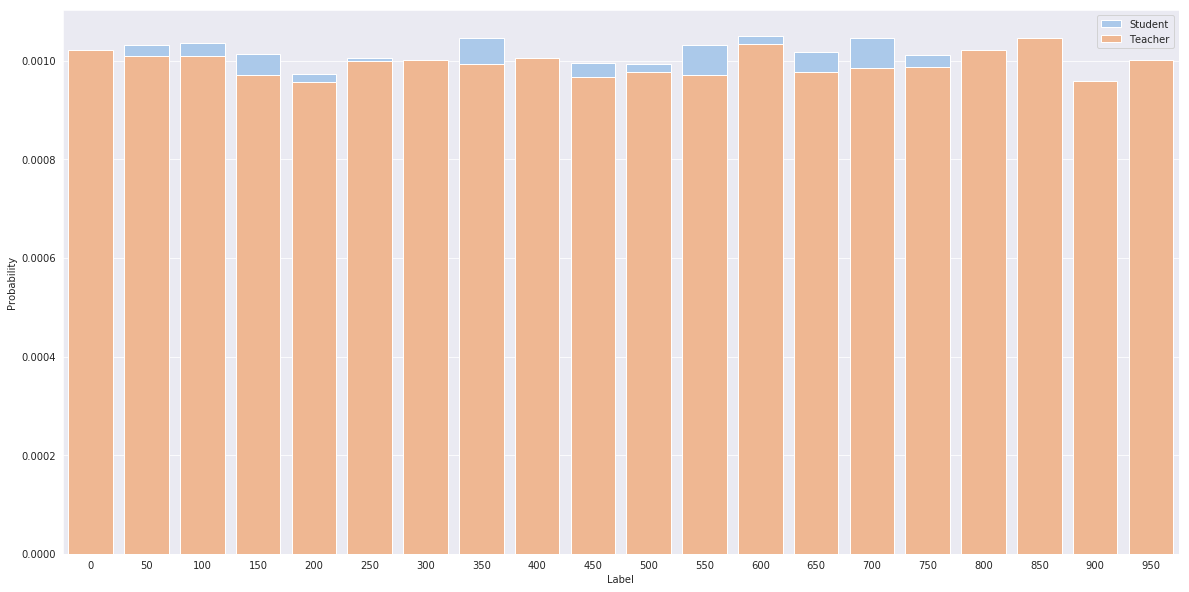

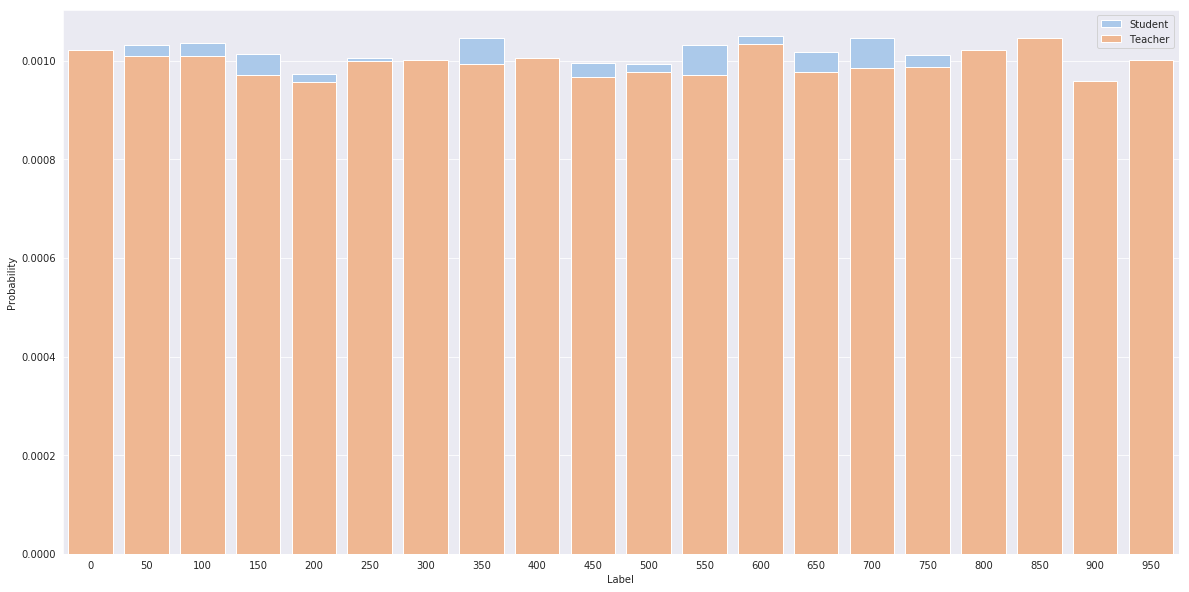

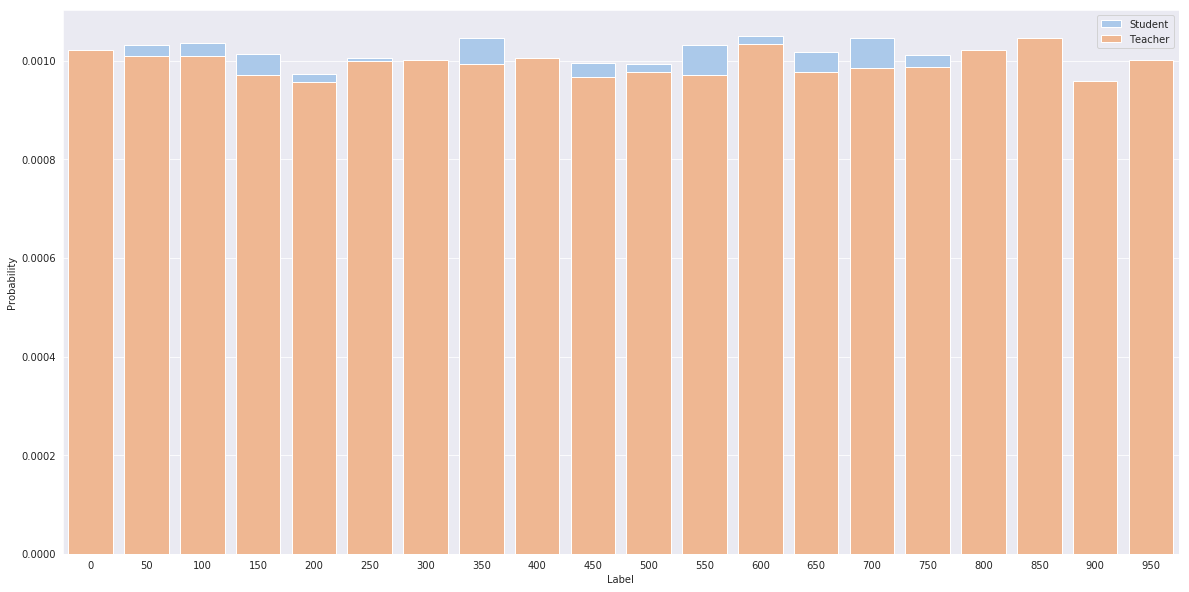

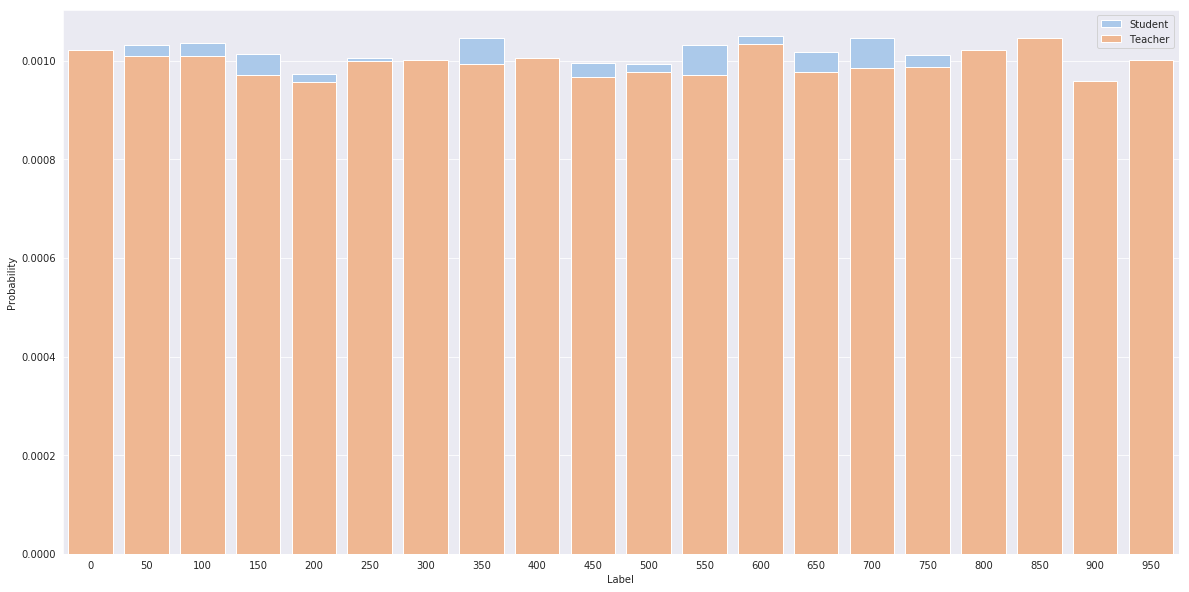

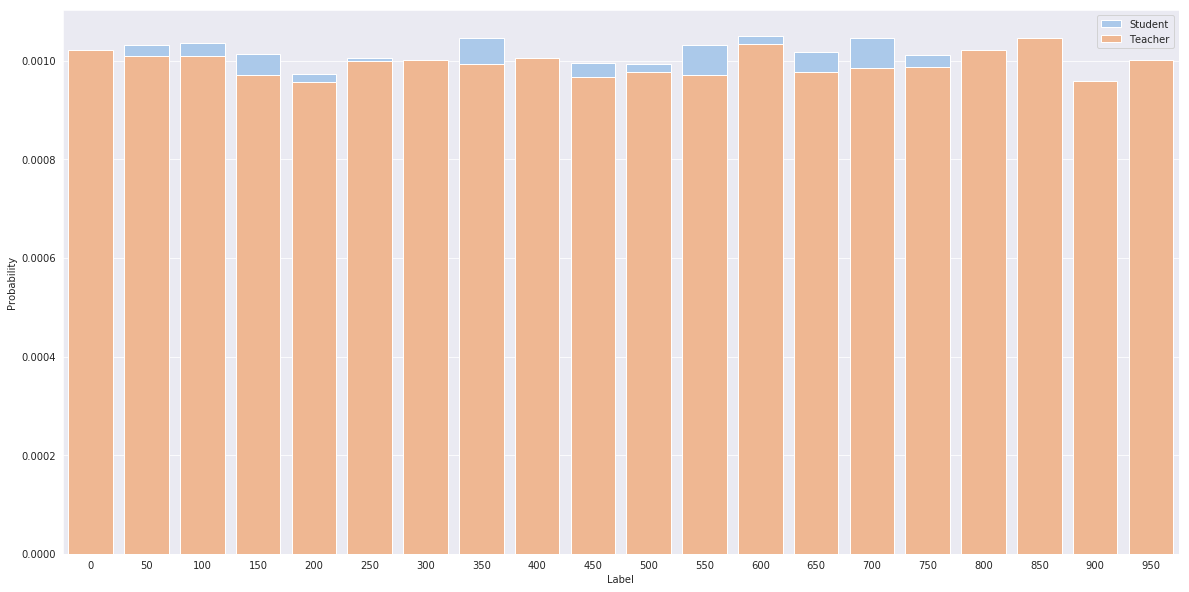

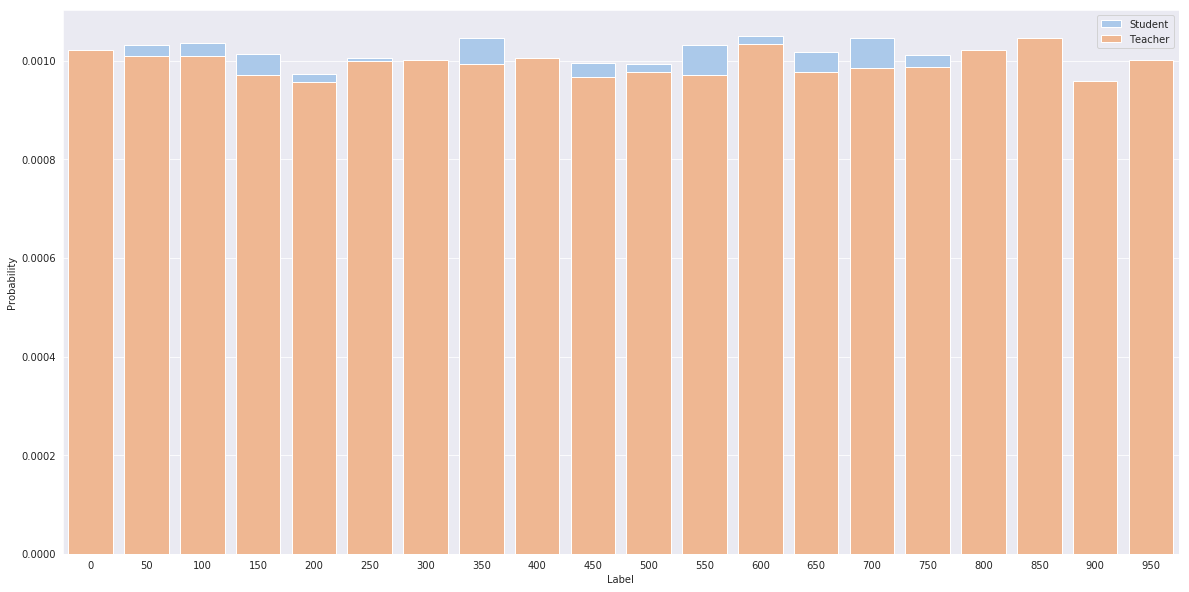

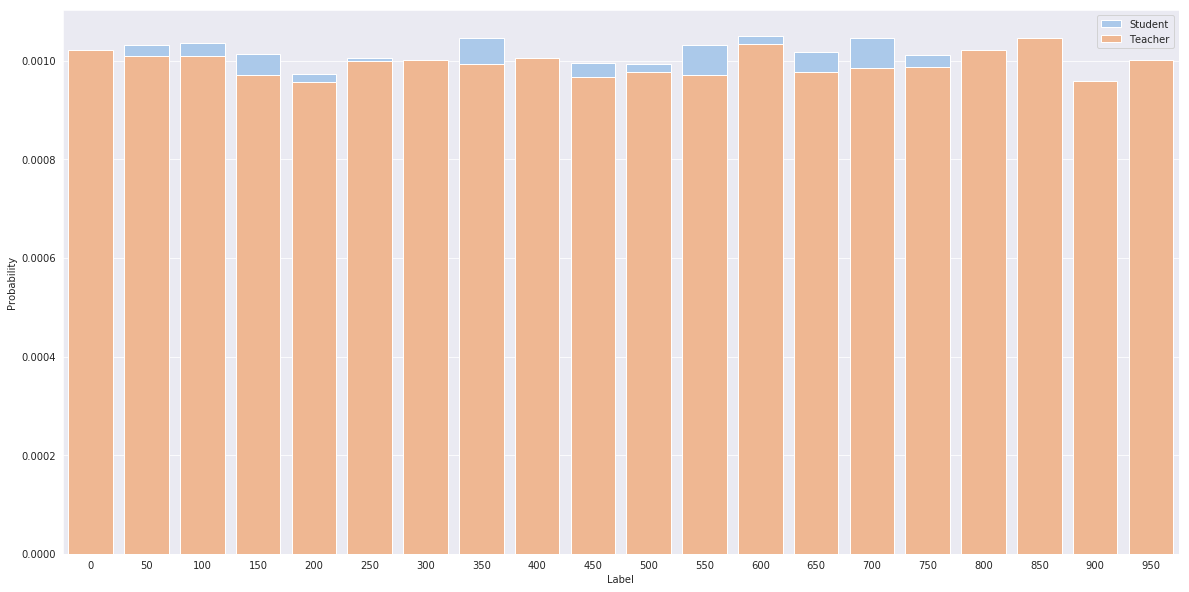

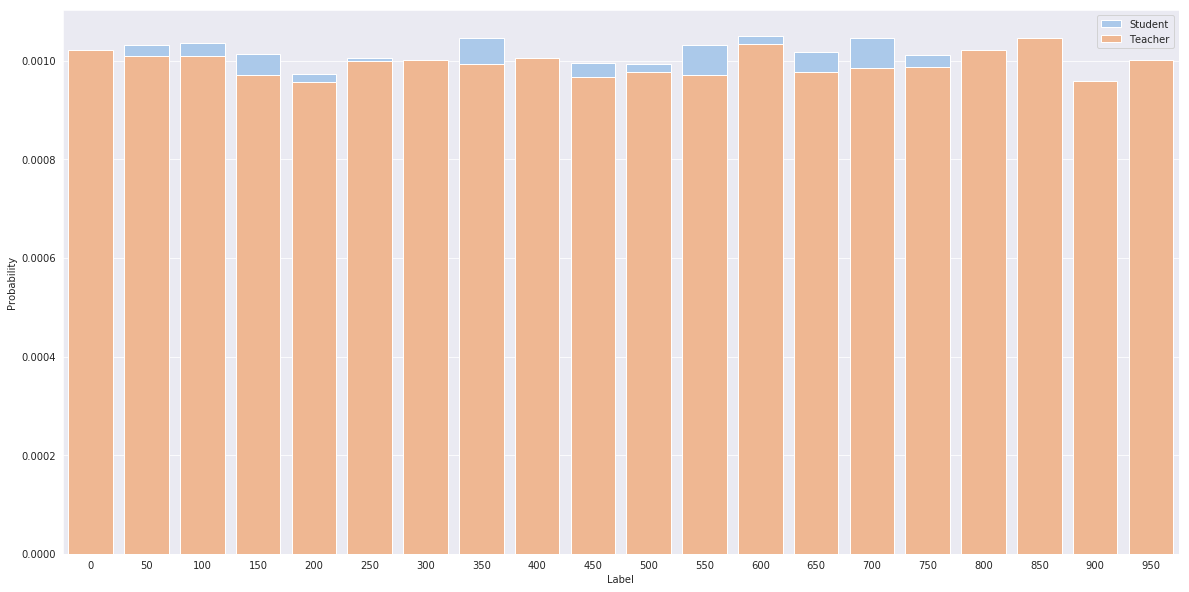

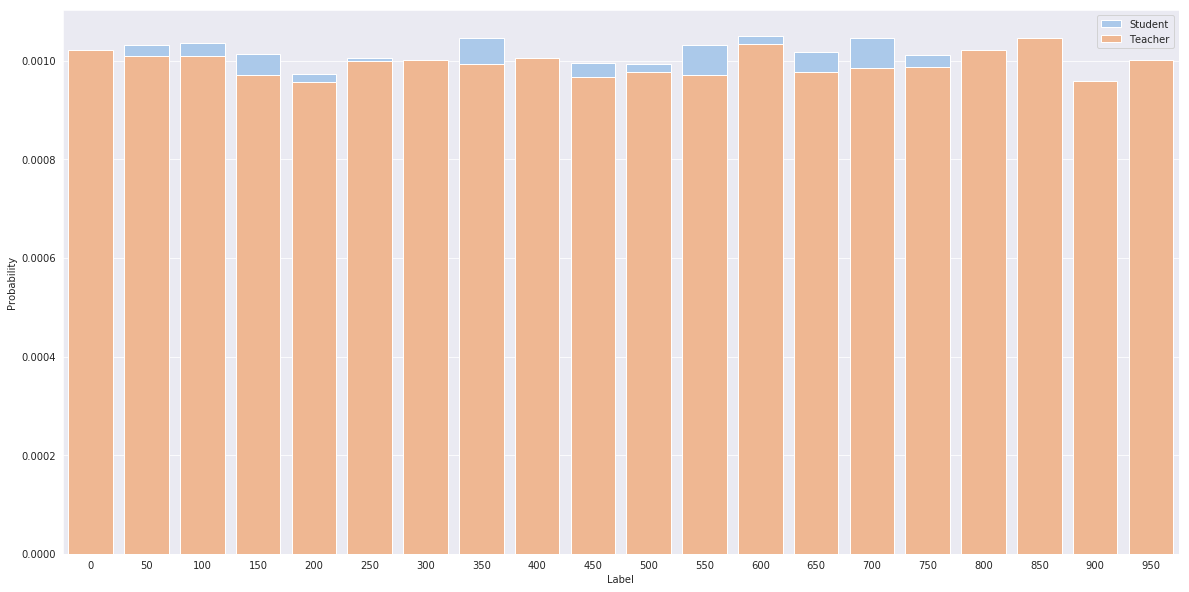

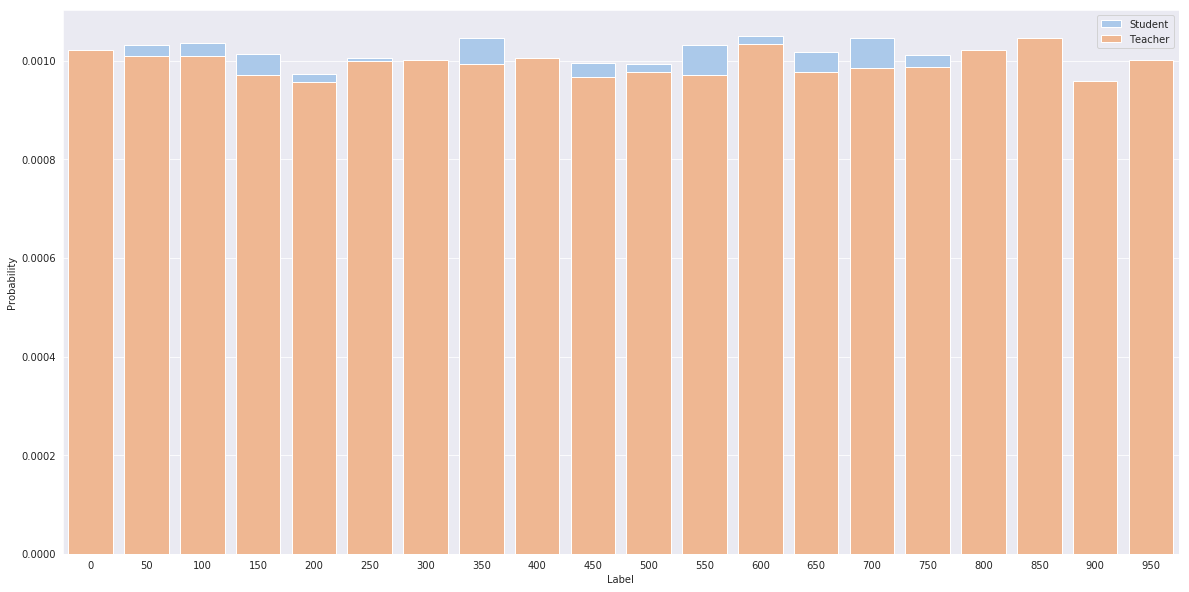

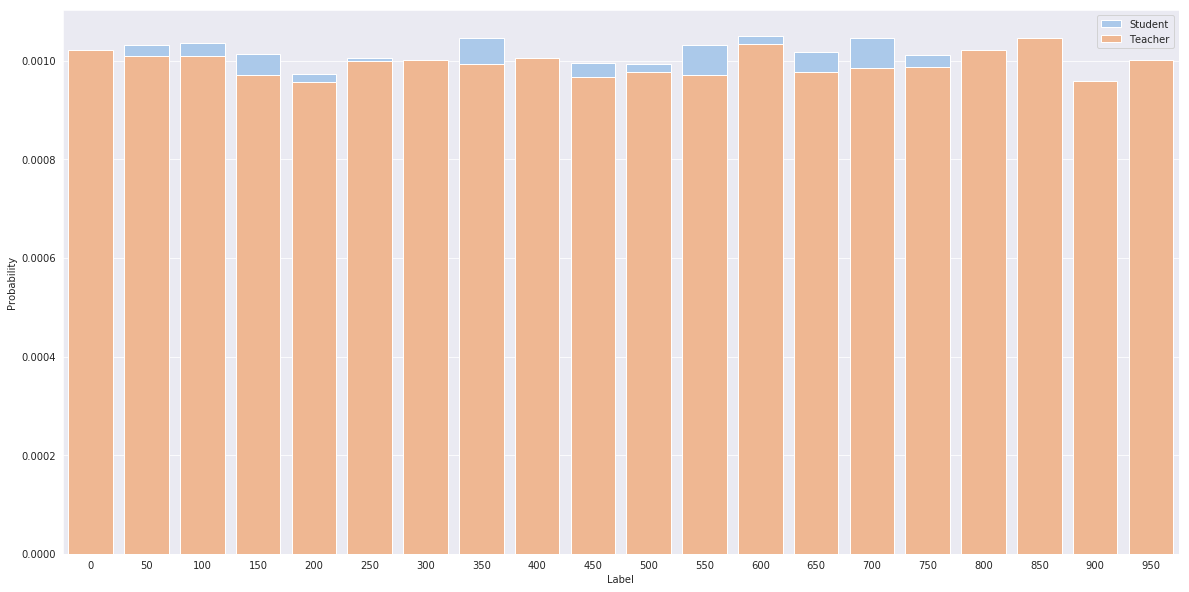

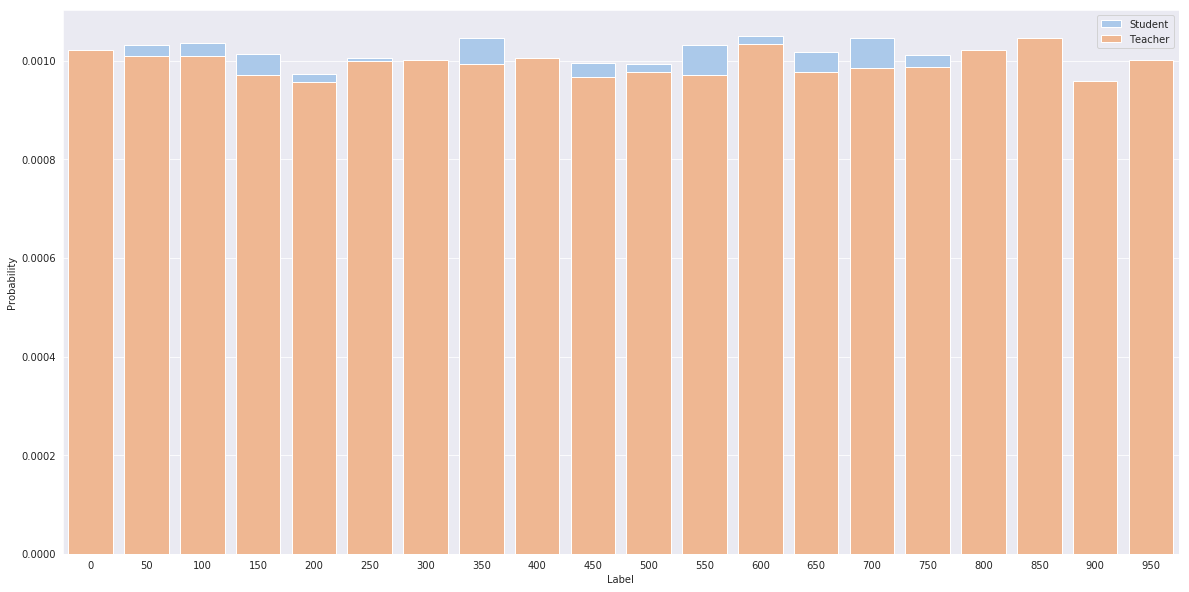

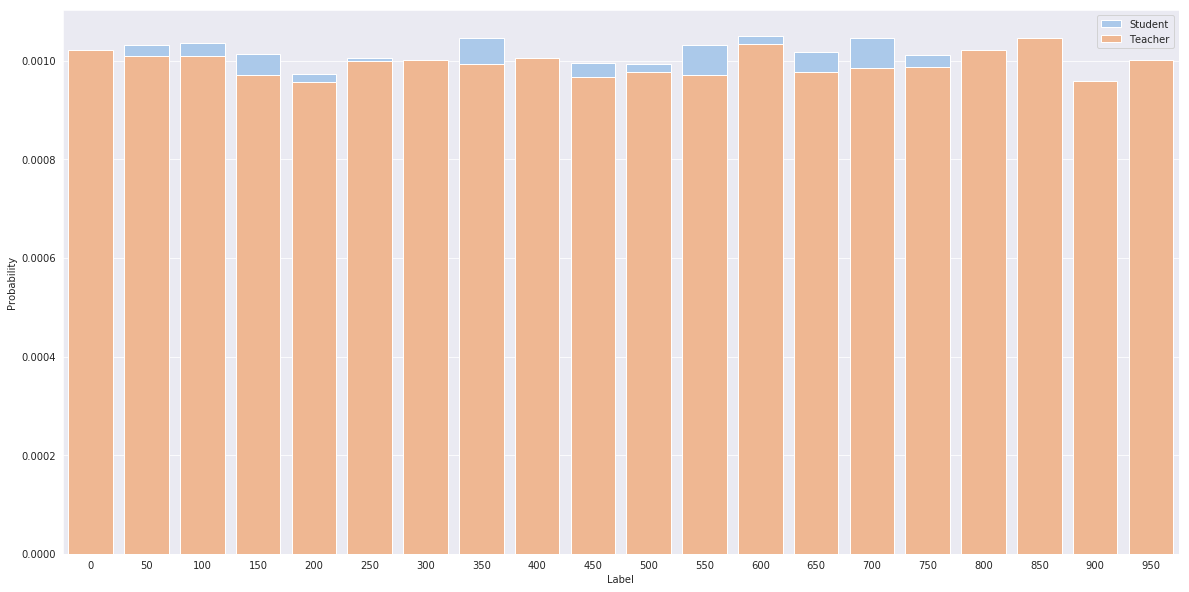

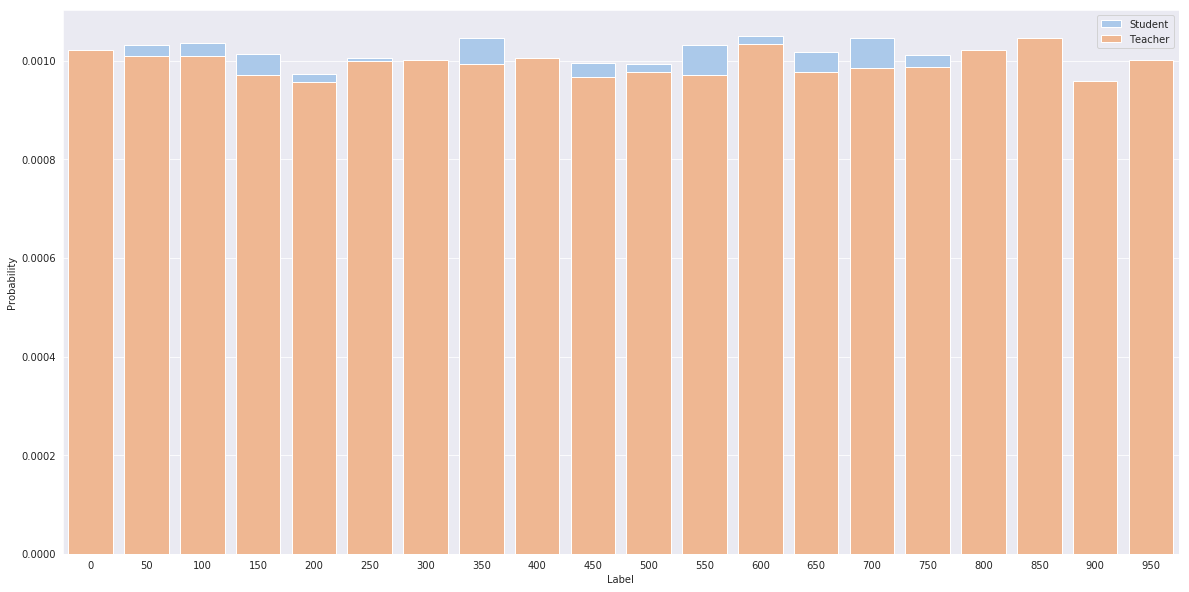

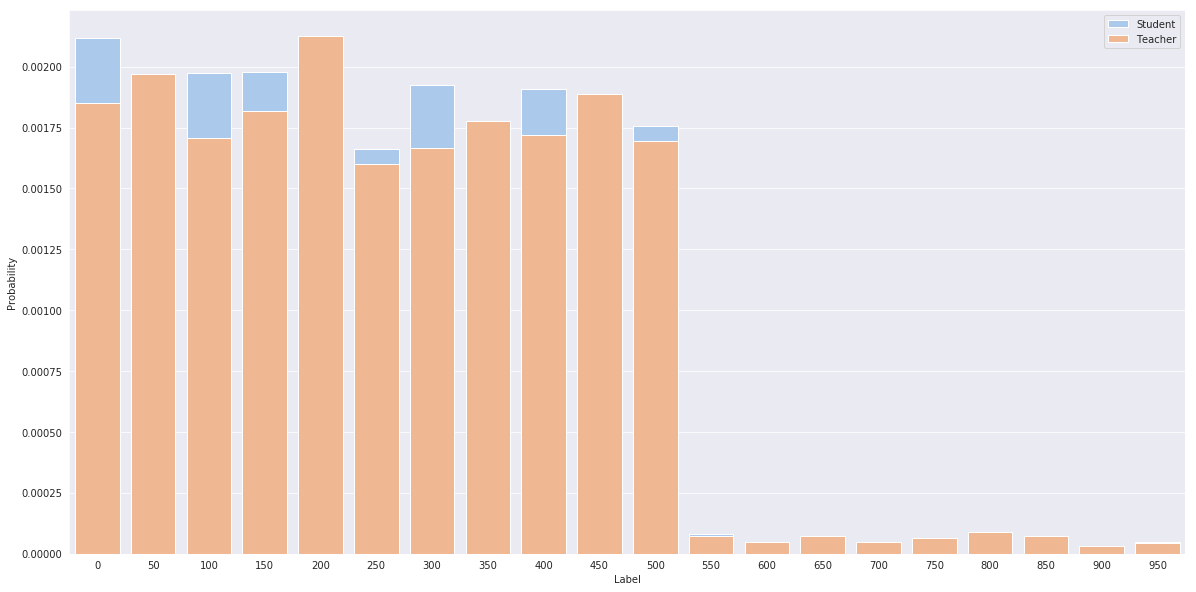

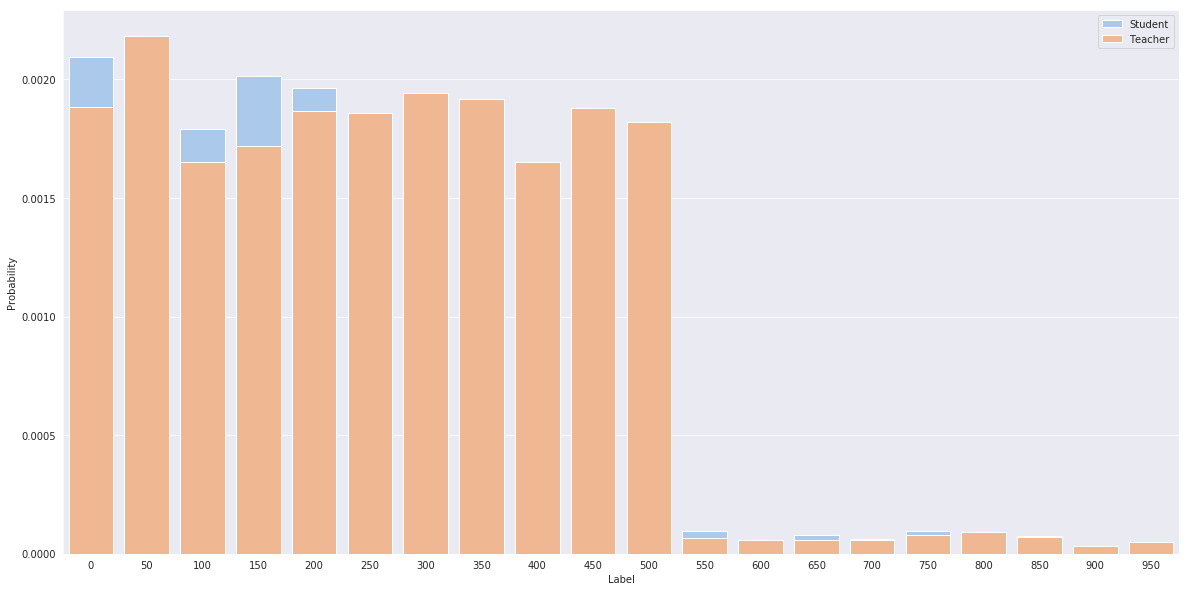

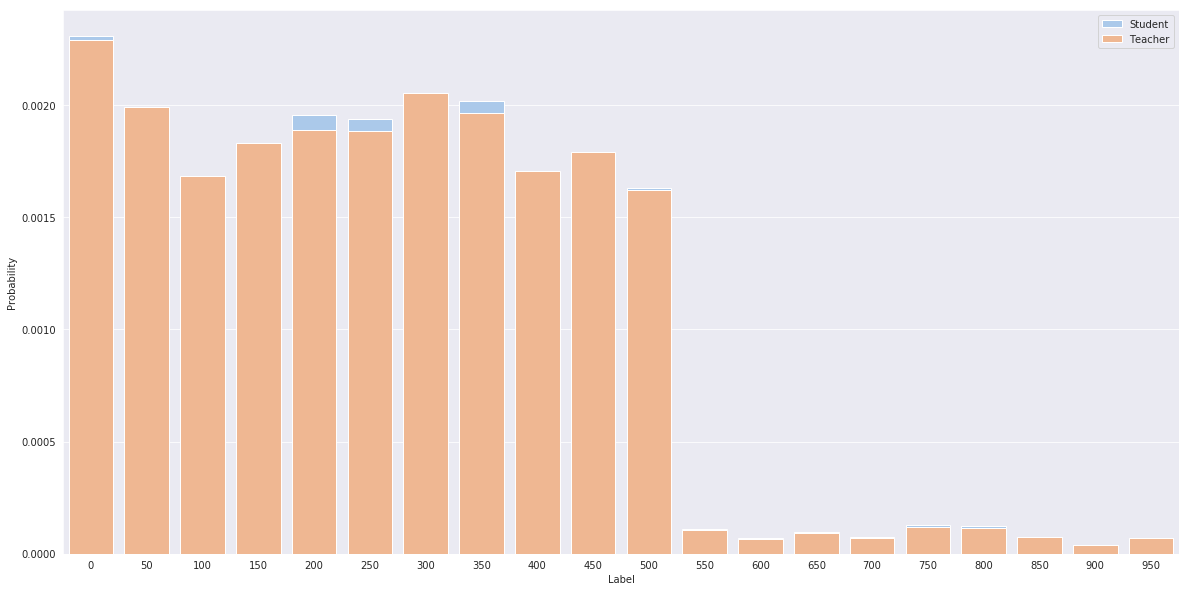

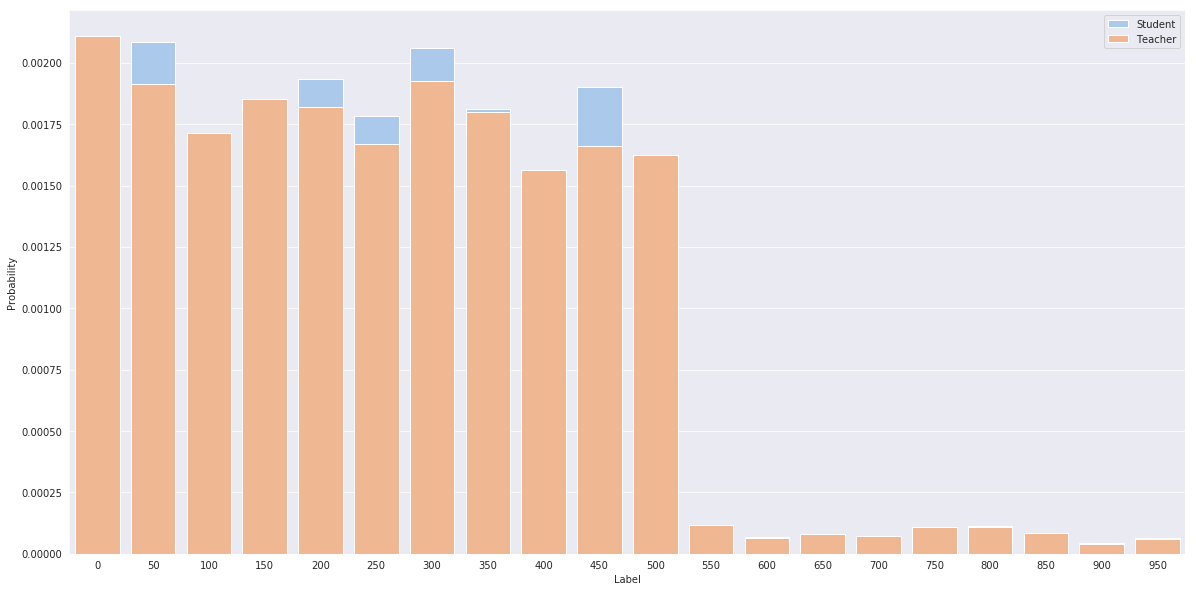

In [57]:
select_labels = np.arange(0, 1000, 50)

for i in range(dists.size(0)):

    label_dist = pd.DataFrame(dists[i][:,select_labels].numpy())
    
    fig = plt.figure(figsize=(5,5))
    sns.barplot(select_labels, 
                label_dist.iloc[0],
                color=colors[0],
                label="Student")
    sns.barplot(select_labels, 
                label_dist.iloc[1],
                color=colors[1],
                label='Teacher')
    plt.xlabel("Label")
    plt.ylabel("Probability")
    plt.legend()

In [74]:
labels = pd.DataFrame(dists[0].numpy())
labels.index = ['Student', 'Teacher']
labels.index.name = "Model"
    
labels_melt = pd.melt(labels.reset_index(), id_vars = ["Model"], var_name="Label", value_name="Est")
labels_melt['Ckpt'] = 0


for i in range(1, dists.size(0)):
    labels = pd.DataFrame(dists[i].numpy())
    labels.index = ['Student', 'Teacher']
    labels.index.name = "Model"
    
    labels_melt_ = pd.melt(labels.reset_index(), id_vars = ["Model"], var_name="Label", value_name="Est")
    labels_melt_['Ckpt'] = 25 * i if i < dists.size(0) -1 else 415
    
    labels_melt = pd.concat([labels_melt, labels_melt_])
    
labels_melt = labels_melt[['Ckpt', "Model", 'Label', "Est"]]
    

/home/ijh216/pytorch/py3.6.3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x2520 with 0 Axes>

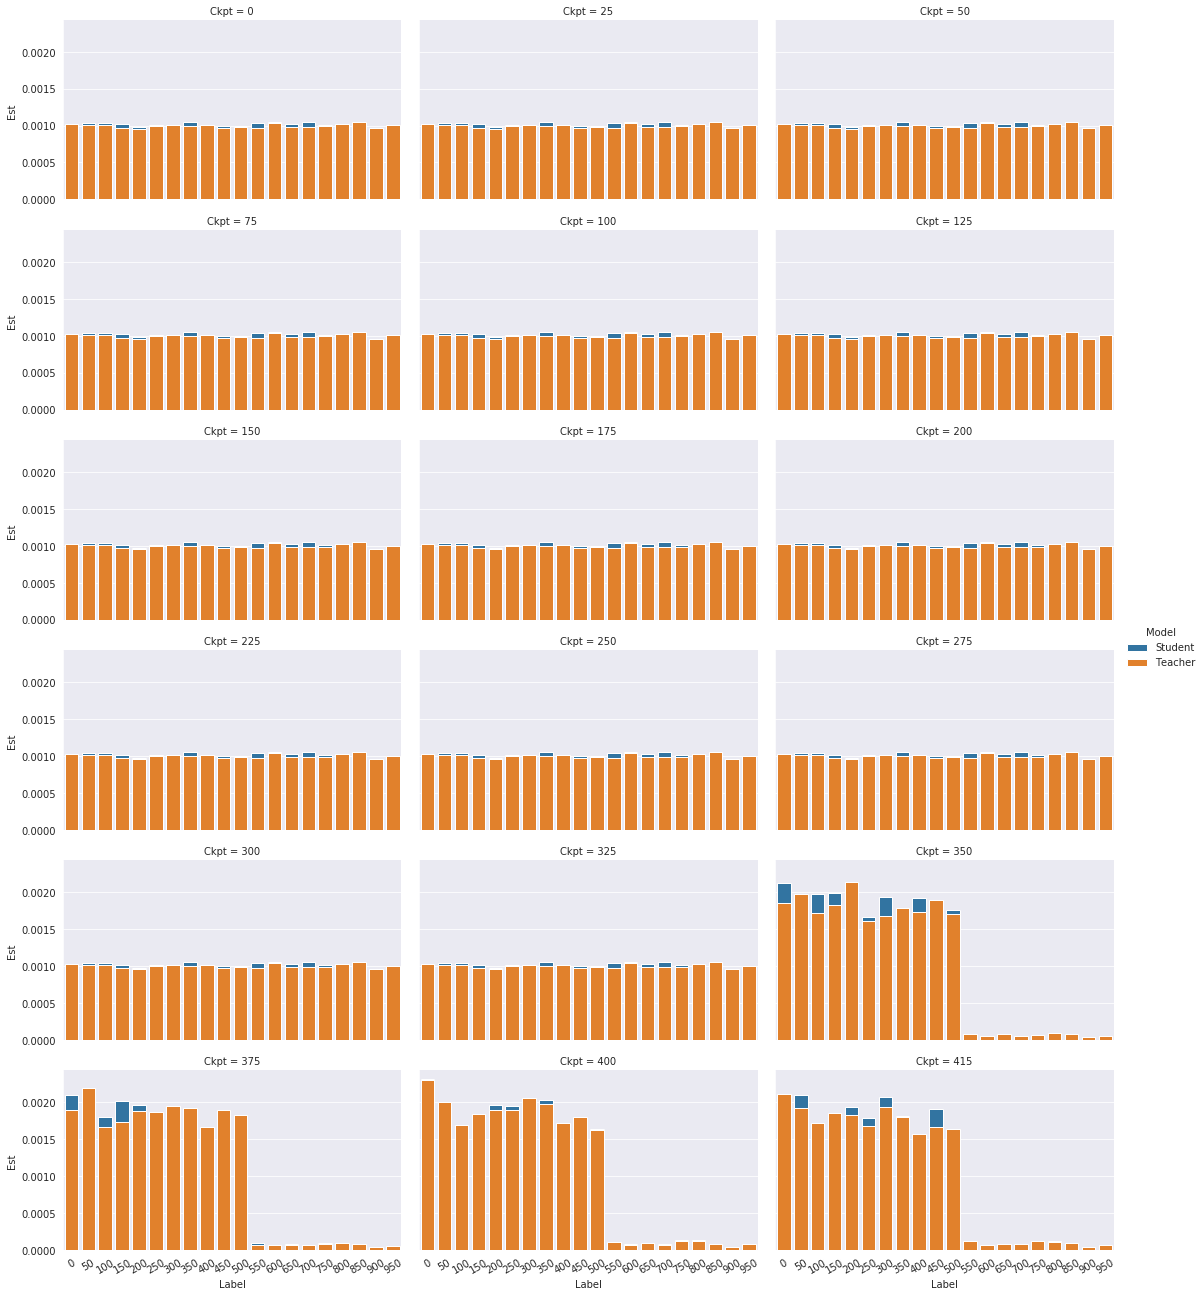

In [115]:
ll_tt = labels_melt.loc[labels_melt['Label'].isin(select_labels)].copy()

fig = plt.figure(figsize=(20,35))
fig.tight_layout()
g = sns.FacetGrid(ll_tt,
                  col='Ckpt',
                  hue='Model', 
                  col_wrap=3,
                  height=3,
                  aspect=1.75
                 )
g = g.map(sns.barplot, "Label", "Est", label="Model")
g.set_xticklabels(rotation=30)
g.add_legend()

In [111]:
?sns.FacetGrid

In [86]:
import os